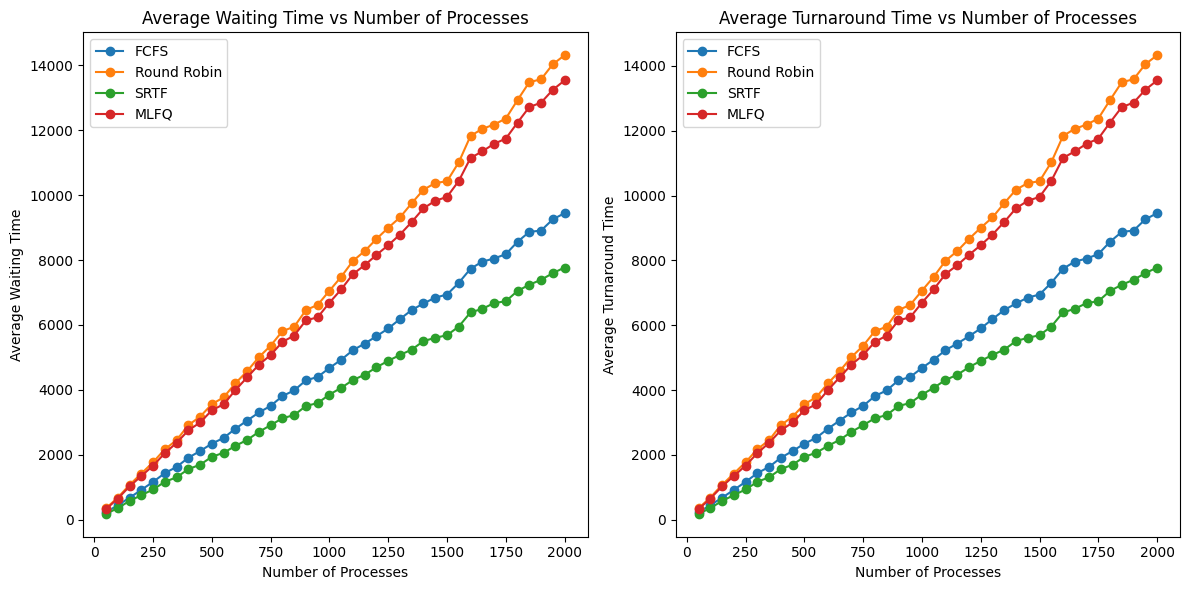

In [12]:
import random
import time
import numpy as np
from tabulate import tabulate
import copy
import matplotlib.pyplot as plt


class Process:
    def __init__(self, pid, burst_time, arrival_time):
        self.pid = pid
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.arrival_time = arrival_time
        self.turnaround_time = 0
        self.waiting_time = 0
        self.response_time = -1
        self.start_time = 0

def first_come_first_serve(processes):
    processes.sort(key=lambda p: p.arrival_time)
    
    time_elapsed = 0
    for process in processes:
        if time_elapsed < process.arrival_time:
            time_elapsed = process.arrival_time
        
        process.start_time = time_elapsed
        process.waiting_time = time_elapsed - process.arrival_time
        process.response_time = process.start_time - process.arrival_time
        time_elapsed += process.burst_time
        process.turnaround_time = time_elapsed - process.arrival_time
        process.remaining_time = 0
        
def round_robin(processes, time_quantum):
    remaining = len(processes) 
    processes.sort(key=lambda p: p.arrival_time) 
    time = processes[0].arrival_time  
    
    while remaining > 0:
        noprocready = True  
        
        for process in processes:
            if process.arrival_time <= time and process.remaining_time > 0:
                noprocready = False 
                
                if process.start_time == 0:
                    process.start_time = time
                    process.response_time = time - process.arrival_time
                
                if process.remaining_time > time_quantum:
                    time += time_quantum
                    process.remaining_time -= time_quantum
                else: 
                    time += process.remaining_time
                    process.waiting_time = time - process.burst_time - process.arrival_time
                    process.turnaround_time = time - process.arrival_time
                    process.remaining_time = 0
                    remaining -= 1  
        
        if noprocready:
            time += 1

def shortest_remaining_time_first(processes):
    
    processes.sort(key=lambda p: p.arrival_time)
    time = processes[0].arrival_time

    while any(p.remaining_time > 0 for p in processes):  
        available_processes = [p for p in processes if p.arrival_time <= time and p.remaining_time > 0]
        
        if available_processes:
            current_process = min(available_processes, key=lambda p: p.remaining_time)
            
            if current_process.start_time == 0:
                current_process.start_time = time
                current_process.response_time = time - current_process.arrival_time
            
            current_process.remaining_time -= 1
            time += 1

            if current_process.remaining_time == 0:
                current_process.turnaround_time = time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
        else:
            time += 1

def multilevel_feedback_queue(processes, time_quantums):
    """
    Multilevel Feedback Queue with FCFS in the last queue.
    
    Args:
        processes (list of Process): List of process objects.
        time_quantums (list of int): Time quantums for the first n-1 queues.
    """
    # Initialize queues; last queue is FCFS
    queues = [[] for _ in range(len(time_quantums) + 1)]
    time = min(p.arrival_time for p in processes)  # Start at the earliest arrival time
    remaining_processes = len(processes)
    processes = sorted(processes, key=lambda p: p.arrival_time)  # Sort by arrival time

    # Add all processes to the first queue
    for process in processes:
        queues[0].append(process)

    while remaining_processes > 0:
        executed = False
        for i in range(len(queues)):
            while queues[i]:
                process = queues[i].pop(0)

                # Ensure the CPU waits until the process arrives
                if process.arrival_time > time:
                    time = process.arrival_time

                # Record the response time if the process is starting for the first time
                if process.response_time == -1:
                    process.response_time = time - process.arrival_time

                if i == len(queues) - 1:  # Last queue (FCFS)
                    # Execute to completion
                    time += process.remaining_time
                    process.remaining_time = 0
                    process.waiting_time = time - process.burst_time - process.arrival_time
                    process.turnaround_time = time - process.arrival_time
                    remaining_processes -= 1
                    executed = True
                else:  # Non-FCFS queues
                    if process.remaining_time > time_quantums[i]:
                        # Execute for the time quantum and demote to the next queue
                        time += time_quantums[i]
                        process.remaining_time -= time_quantums[i]
                        executed = True
                        queues[i + 1].append(process)  # Demote to next queue
                    else:
                        # Execute to completion
                        time += process.remaining_time
                        process.remaining_time = 0
                        process.waiting_time = time - process.burst_time - process.arrival_time
                        process.turnaround_time = time - process.arrival_time
                        remaining_processes -= 1
                        executed = True

        # If no process was executed, increment time (idle CPU)
        if not executed:
            time += 1
 
def calculate_averages(processes):
    avg_waiting_time = np.mean([p.waiting_time for p in processes])
    avg_turnaround_time = np.mean([p.turnaround_time for p in processes])
    return avg_waiting_time, avg_turnaround_time

def plot_avg_times(results, process_range):
    fcfs_waiting = [result[0] for result in results["FCFS"]]
    fcfs_turnaround = [result[1] for result in results["FCFS"]]
    rr_waiting = [result[0] for result in results["RR"]]
    rr_turnaround = [result[1] for result in results["RR"]]
    srtf_waiting = [result[0] for result in results["SRTF"]]
    srtf_turnaround = [result[1] for result in results["SRTF"]]
    mlfq_waiting = [result[0] for result in results["MLFQ"]]
    mlfq_turnaround = [result[1] for result in results["MLFQ"]]
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(process_range, fcfs_waiting, label="FCFS", marker="o")
    plt.plot(process_range, rr_waiting, label="Round Robin", marker="o")
    plt.plot(process_range, srtf_waiting, label="SRTF", marker="o")
    plt.plot(process_range, mlfq_waiting,label="MLFQ", marker = 'o')
    plt.title("Average Waiting Time vs Number of Processes")
    plt.xlabel("Number of Processes")
    plt.ylabel("Average Waiting Time")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(process_range, fcfs_turnaround, label="FCFS", marker="o")
    plt.plot(process_range, rr_turnaround, label="Round Robin", marker="o")
    plt.plot(process_range, srtf_turnaround, label="SRTF", marker="o")
    plt.plot(process_range, mlfq_turnaround, label="MLFQ", marker="o")
    plt.title("Average Turnaround Time vs Number of Processes")
    plt.xlabel("Number of Processes")
    plt.ylabel("Average Turnaround Time")
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    process_range = []
    results = {"FCFS": [], "RR": [], "SRTF": [], "MLFQ": []}

    time_quantum = int(input("Enter the time quantum for Round Robin: "))
    mlfq_quantums = list(map(int, input("Enter the time quantums for MLFQ (comma-separated): ").split(',')))

    random.seed(int(time.time()))
# Don't forget to change 201
    for n in range(50, 2001, 50): 
        process_range.append(n)
        processes = []
        
        arrival_min = 0
        arrival_max = 50

        burst_mean = 10
        burst_stddev = 3

        for i in range(n):
            arrival_time = random.randint(arrival_min, arrival_max)  
            burst_time = max(1, int(np.random.normal(burst_mean, burst_stddev))) 
            processes.append(Process(i + 1, burst_time, arrival_time))
        
        processes_copy = copy.deepcopy(processes)
        first_come_first_serve(processes_copy)
        avg_waiting, avg_turnaround = calculate_averages(processes_copy)
        results["FCFS"].append((avg_waiting, avg_turnaround))

        processes_copy = copy.deepcopy(processes)
        round_robin(processes_copy, time_quantum)
        avg_waiting, avg_turnaround = calculate_averages(processes_copy)
        results["RR"].append((avg_waiting, avg_turnaround))

        processes_copy = copy.deepcopy(processes)
        shortest_remaining_time_first(processes_copy)
        avg_waiting, avg_turnaround = calculate_averages(processes_copy)
        results["SRTF"].append((avg_waiting, avg_turnaround))
        
        processes_copy = copy.deepcopy(processes)
        multilevel_feedback_queue(processes_copy, mlfq_quantums)
        avg_waiting, avg_turnaround = calculate_averages(processes_copy)
        results["MLFQ"].append((avg_waiting, avg_turnaround))
    
    plot_avg_times(results, process_range)

if __name__ == "__main__":
    main()

In [ ]:
# def display_schedule(processes):
#     headers = ["Process ID", "Burst", "Remaining", "Arrival", "Start", "Turnaround", "Waiting", "Response"]
#     table = [
#         [
#             process.pid,
#             process.burst_time,
#             process.remaining_time,
#             process.arrival_time,
#             process.start_time,
#             process.turnaround_time,
#             process.waiting_time,
#             process.response_time,
#         ]
#         for process in processes
#     ]
#     print(tabulate(table, headers=headers, tablefmt="pretty"))
# def main():
#     n = int(input("Enter the number of processes: "))
#     time_quantum = int(input("Enter the time quantum for Round Robin: "))
#     random.seed(int(time.time()))  
    
#     arrival_min = 0
#     arrival_max = 50

#     burst_mean = 10
#     burst_stddev = 3

#     processes = []
#     for i in range(n):
#         arrival_time = random.randint(arrival_min, arrival_max)  
#         burst_time = max(1, int(np.random.normal(burst_mean, burst_stddev))) 
#         processes.append(Process(i + 1, burst_time, arrival_time))
#     processes_copy = copy.deepcopy(processes)
#     first_come_first_serve(processes_copy)
#     print('First Come First Serve: ')
#     display_schedule(processes_copy)
#     print("\n")
#     processes_copy = copy.deepcopy(processes)
#     print('Round Robin: ')
#     round_robin(processes_copy, time_quantum)
#     display_schedule(processes_copy)
#     print("\n")
#     processes_copy = copy.deepcopy(processes)
#     print('Shortest Remaining Time First: ')
#     shortest_remaining_time_first(processes_copy)
#     display_schedule(processes_copy)